<h1>IQPEmbedding</h1>

In [1]:
# Importing modules
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers, IQPEmbedding
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt



In [2]:
# Setting parameters

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/IQPEmbedding" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
# Loading of the MNIST dataset

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)



In [4]:
"""
We initialize a PennyLane default.qubit device, simulating a system of 4

qubits. The associated qnode represents the quantum circuit consisting of:

1) an embedding layer of local Ry rotations (with angles scaled by a factor of π);
2) a random circuit of n_layers;
3) a final measurement in the computational basis, estimating 4 expectation values.
"""

dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def circuit(features,repeat):
    # Encoding of 4 classical input values
    IQPEmbedding(features, wires =range(4), n_repeats=repeat)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [5]:
"""
The next function defines the convolution scheme:

1)the image is divided into squares of 2×2 pixels;
2)each square is processed by the quantum circuit;
3)the 4 expectation values are mapped into 4 different channels of a single output pixel.
"""

def quanv(image,repeat):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ], repeat
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out



In [6]:
def Process(repeat):
    if PREPROCESS == True:
        q_train_images = []
        print("Quantum pre-processing of train images:")
        for idx, img in enumerate(train_images):
            print("{}/{}        ".format(idx + 1, n_train), end="\r")
            q_train_images.append(quanv(img,repeat))
        q_train_images = np.asarray(q_train_images)

        q_test_images = []
        print("\nQuantum pre-processing of test images:")
        for idx, img in enumerate(test_images):
            print("{}/{}        ".format(idx + 1, n_test), end="\r")
            q_test_images.append(quanv(img,repeat))
        q_test_images = np.asarray(q_test_images)

        # Save pre-processed images
        np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
        np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


    # Load pre-processed images
    q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
    q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

    return q_train_images, q_test_images

In [7]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [8]:
def Train_model(epochs):
    q_model = MyModel()

    q_history = q_model.fit(
        q_train_images,
        train_labels,
        validation_data=(q_test_images, test_labels),
        batch_size=4,
        epochs=epochs,
        verbose=2,
    )

    c_model = MyModel()

    c_history = c_model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        batch_size=4,
        epochs=epochs,
        verbose=2,
    )
    return q_history, c_history
    

<h1> Repeats </h1>

<h2> Repeat = 1 </h2>

In [9]:
q_train_images, q_test_images = Process(1) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


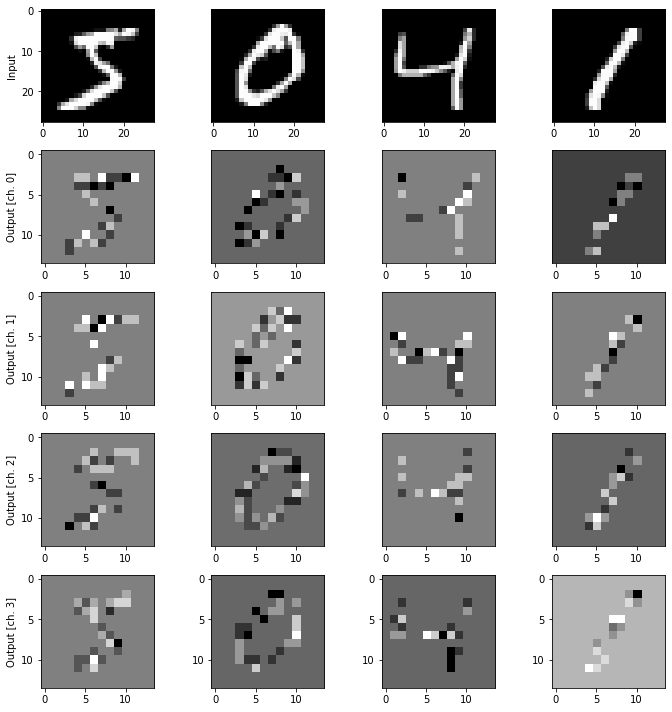

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 2.3028 - accuracy: 0.0400 - val_loss: 2.3020 - val_accuracy: 0.1333
Epoch 2/50
13/13 - 0s - loss: 2.3018 - accuracy: 0.1400 - val_loss: 2.3020 - val_accuracy: 0.1333
Epoch 3/50
13/13 - 0s - loss: 2.3012 - accuracy: 0.1400 - val_loss: 2.3021 - val_accuracy: 0.1333
Epoch 4/50
13/13 - 0s - loss: 2.3007 - accuracy: 0.1400 - val_loss: 2.3019 - val_accuracy: 0.1333
Epoch 5/50
13/13 - 0s - loss: 2.3000 - accuracy: 0.1400 - val_loss: 2.3015 - val_accuracy: 0.1333
Epoch 6/50
13/13 - 0s - loss: 2.2995 - accuracy: 0.1400 - val_loss: 2.3015 - val_accuracy: 0.1333
Epoch 7/50
13/13 - 0s - loss: 2.2989 - accuracy: 0.1400 - val_loss: 2.3014 - val_accuracy: 0.1333
Epoch 8/50
13/13 - 0s - loss: 2.2985 - accuracy: 0.1400 - val_loss: 2.3012 - val_accuracy: 0.1333
Epoch 9/50
13/13 - 0s - loss: 2.2979 - accuracy: 0.0800 - val_loss: 2.3008 - val_accuracy: 0.1667
Epoch 10/50
13/13 - 0s - loss: 2.2973 - accuracy: 0.1400 - val_loss: 2.3008 - val_accuracy: 0.1667
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1132 - accuracy: 1.0000 - val_loss: 1.0679 - val_accuracy: 0.6667
Epoch 35/50
13/13 - 0s - loss: 0.1071 - accuracy: 1.0000 - val_loss: 1.0632 - val_accuracy: 0.6667
Epoch 36/50
13/13 - 0s - loss: 0.1028 - accuracy: 1.0000 - val_loss: 1.0604 - val_accuracy: 0.6667
Epoch 37/50
13/13 - 0s - loss: 0.0981 - accuracy: 1.0000 - val_loss: 1.0561 - val_accuracy: 0.6667
Epoch 38/50
13/13 - 0s - loss: 0.0939 - accuracy: 1.0000 - val_loss: 1.0527 - val_accuracy: 0.6667
Epoch 39/50
13/13 - 0s - loss: 0.0902 - accuracy: 1.0000 - val_loss: 1.0421 - val_accuracy: 0.6667
Epoch 40/50
13/13 - 0s - loss: 0.0863 - accuracy: 1.0000 - val_loss: 1.0398 - val_accuracy: 0.6667
Epoch 41/50
13/13 - 0s - loss: 0.0828 - accuracy: 1.0000 - val_loss: 1.0357 - val_accuracy: 0.6667
Epoch 42/50
13/13 - 0s - loss: 0.0794 - accuracy: 1.0000 - val_loss: 1.0366 - val_accuracy: 0.6667
Epoch 43/50
13/13 - 0s - loss: 0.0764 - accuracy: 1.0000 - val_loss: 1.0353 - val_accuracy: 0.6667
Epoch 44/5

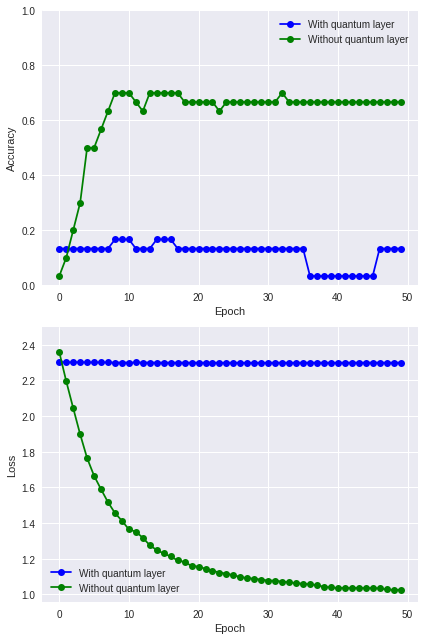

In [12]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()


<h2> Repeat = 2 </h2>

In [13]:
q_train_images, q_test_images = Process(2) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


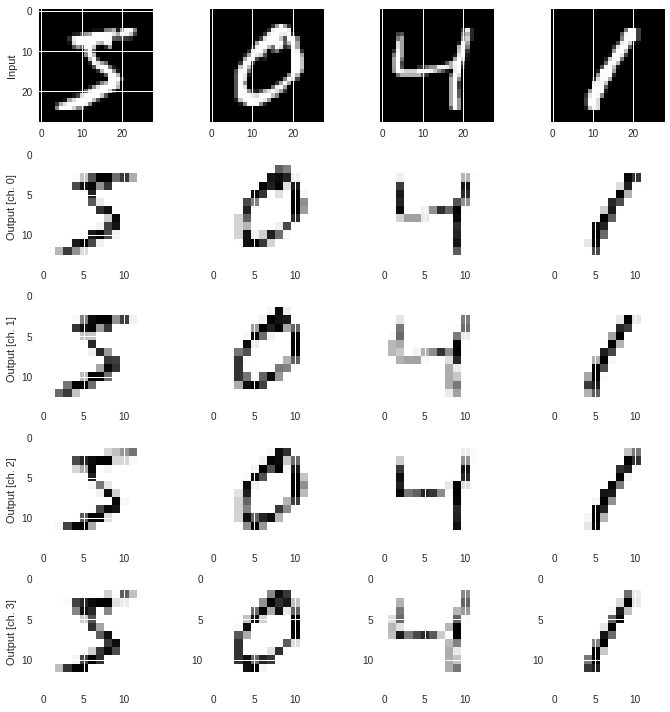

In [14]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [15]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [16]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 2.9915 - accuracy: 0.0800 - val_loss: 2.3817 - val_accuracy: 0.0667
Epoch 2/50
13/13 - 0s - loss: 2.5231 - accuracy: 0.0400 - val_loss: 2.2986 - val_accuracy: 0.1667
Epoch 3/50
13/13 - 0s - loss: 2.3382 - accuracy: 0.1400 - val_loss: 2.2688 - val_accuracy: 0.1667
Epoch 4/50
13/13 - 0s - loss: 2.0733 - accuracy: 0.2200 - val_loss: 2.0768 - val_accuracy: 0.1667
Epoch 5/50
13/13 - 0s - loss: 2.0845 - accuracy: 0.1600 - val_loss: 2.0485 - val_accuracy: 0.3000
Epoch 6/50
13/13 - 0s - loss: 2.0291 - accuracy: 0.3400 - val_loss: 2.1116 - val_accuracy: 0.3000
Epoch 7/50
13/13 - 0s - loss: 1.8208 - accuracy: 0.4800 - val_loss: 1.8690 - val_accuracy: 0.5000
Epoch 8/50
13/13 - 0s - loss: 1.7775 - accuracy: 0.4800 - val_loss: 1.9260 - val_accuracy: 0.3667
Epoch 9/50
13/13 - 0s - loss: 1.6193 - accuracy: 0.5600 - val_loss: 1.7968 - val_accuracy: 0.5000
Epoch 10/50
13/13 - 0s - loss: 1.4648 - accuracy: 0.7400 - val_loss: 1.8614 - val_accuracy: 0.4000
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1088 - accuracy: 1.0000 - val_loss: 1.0660 - val_accuracy: 0.7000
Epoch 35/50
13/13 - 0s - loss: 0.1031 - accuracy: 1.0000 - val_loss: 1.0619 - val_accuracy: 0.7000
Epoch 36/50
13/13 - 0s - loss: 0.0989 - accuracy: 1.0000 - val_loss: 1.0595 - val_accuracy: 0.7000
Epoch 37/50
13/13 - 0s - loss: 0.0945 - accuracy: 1.0000 - val_loss: 1.0555 - val_accuracy: 0.7000
Epoch 38/50
13/13 - 0s - loss: 0.0906 - accuracy: 1.0000 - val_loss: 1.0525 - val_accuracy: 0.7000
Epoch 39/50
13/13 - 0s - loss: 0.0869 - accuracy: 1.0000 - val_loss: 1.0429 - val_accuracy: 0.7000
Epoch 40/50
13/13 - 0s - loss: 0.0834 - accuracy: 1.0000 - val_loss: 1.0413 - val_accuracy: 0.7000
Epoch 41/50
13/13 - 0s - loss: 0.0801 - accuracy: 1.0000 - val_loss: 1.0373 - val_accuracy: 0.7000
Epoch 42/50
13/13 - 0s - loss: 0.0768 - accuracy: 1.0000 - val_loss: 1.0383 - val_accuracy: 0.7000
Epoch 43/50
13/13 - 0s - loss: 0.0740 - accuracy: 1.0000 - val_loss: 1.0376 - val_accuracy: 0.6667
Epoch 44/5

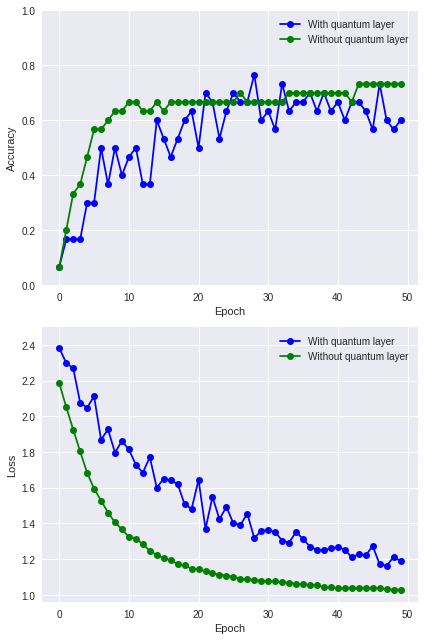

In [17]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 3 </h2>

In [18]:
q_train_images, q_test_images = Process(3) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


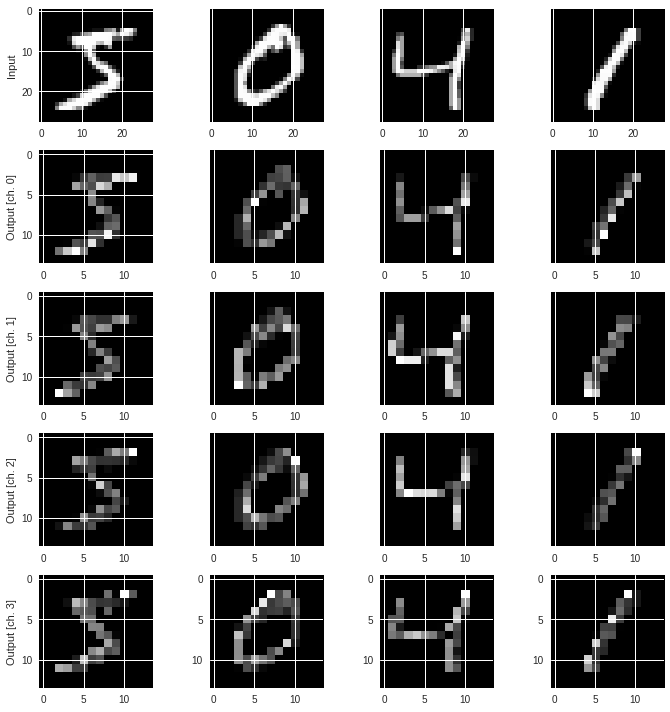

In [19]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [20]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 2.3145 - accuracy: 0.1000 - val_loss: 2.2663 - val_accuracy: 0.2000
Epoch 2/50
13/13 - 0s - loss: 2.1960 - accuracy: 0.2800 - val_loss: 2.2256 - val_accuracy: 0.2000
Epoch 3/50
13/13 - 0s - loss: 2.0883 - accuracy: 0.4600 - val_loss: 2.1871 - val_accuracy: 0.2667
Epoch 4/50
13/13 - 0s - loss: 1.9901 - accuracy: 0.5000 - val_loss: 2.1468 - val_accuracy: 0.3667
Epoch 5/50
13/13 - 0s - loss: 1.8933 - accuracy: 0.6200 - val_loss: 2.1027 - val_accuracy: 0.4000
Epoch 6/50
13/13 - 0s - loss: 1.8056 - accuracy: 0.6600 - val_loss: 2.0660 - val_accuracy: 0.4000
Epoch 7/50
13/13 - 0s - loss: 1.7184 - accuracy: 0.7000 - val_loss: 2.0312 - val_accuracy: 0.4000
Epoch 8/50
13/13 - 0s - loss: 1.6352 - accuracy: 0.7200 - val_loss: 1.9927 - val_accuracy: 0.4667
Epoch 9/50
13/13 - 0s - loss: 1.5568 - accuracy: 0.8400 - val_loss: 1.9564 - val_accuracy: 0.5000
Epoch 10/50
13/13 - 0s - loss: 1.4828 - accuracy: 0.9000 - val_loss: 1.9259 - val_accuracy: 0.5000
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1119 - accuracy: 1.0000 - val_loss: 1.0496 - val_accuracy: 0.7000
Epoch 35/50
13/13 - 0s - loss: 0.1059 - accuracy: 1.0000 - val_loss: 1.0463 - val_accuracy: 0.7000
Epoch 36/50
13/13 - 0s - loss: 0.1016 - accuracy: 1.0000 - val_loss: 1.0453 - val_accuracy: 0.7000
Epoch 37/50
13/13 - 0s - loss: 0.0971 - accuracy: 1.0000 - val_loss: 1.0417 - val_accuracy: 0.7000
Epoch 38/50
13/13 - 0s - loss: 0.0930 - accuracy: 1.0000 - val_loss: 1.0400 - val_accuracy: 0.7000
Epoch 39/50
13/13 - 0s - loss: 0.0893 - accuracy: 1.0000 - val_loss: 1.0309 - val_accuracy: 0.7000
Epoch 40/50
13/13 - 0s - loss: 0.0856 - accuracy: 1.0000 - val_loss: 1.0293 - val_accuracy: 0.7000
Epoch 41/50
13/13 - 0s - loss: 0.0821 - accuracy: 1.0000 - val_loss: 1.0263 - val_accuracy: 0.7000
Epoch 42/50
13/13 - 0s - loss: 0.0789 - accuracy: 1.0000 - val_loss: 1.0272 - val_accuracy: 0.7000
Epoch 43/50
13/13 - 0s - loss: 0.0759 - accuracy: 1.0000 - val_loss: 1.0269 - val_accuracy: 0.7000
Epoch 44/5

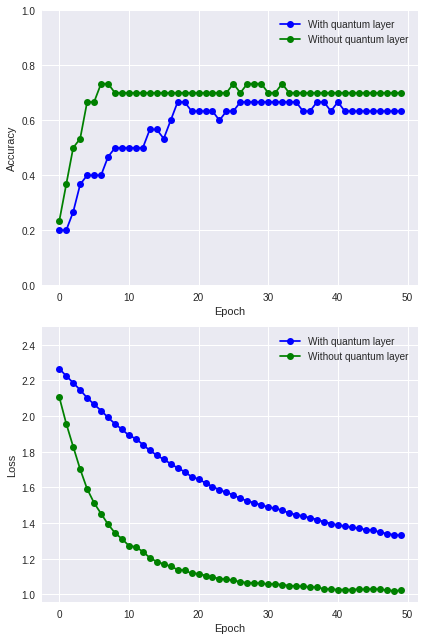

In [21]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 4 </h2>

In [22]:
q_train_images, q_test_images = Process(4) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


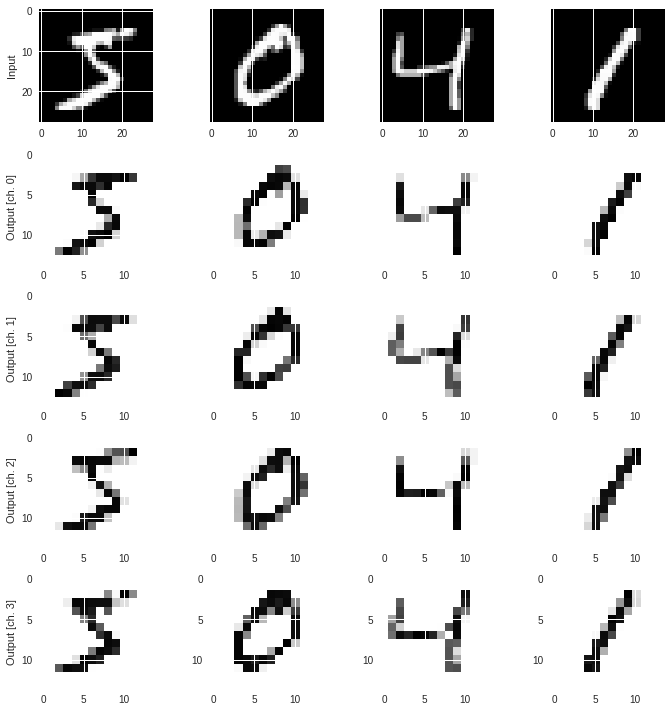

In [23]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [24]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 3.1507 - accuracy: 0.0800 - val_loss: 2.4708 - val_accuracy: 0.0333
Epoch 2/50
13/13 - 0s - loss: 2.3990 - accuracy: 0.2200 - val_loss: 2.2502 - val_accuracy: 0.2333
Epoch 3/50
13/13 - 0s - loss: 2.1810 - accuracy: 0.1600 - val_loss: 2.0737 - val_accuracy: 0.2333
Epoch 4/50
13/13 - 0s - loss: 1.8239 - accuracy: 0.4000 - val_loss: 1.9787 - val_accuracy: 0.1667
Epoch 5/50
13/13 - 0s - loss: 1.7273 - accuracy: 0.4200 - val_loss: 1.8423 - val_accuracy: 0.4667
Epoch 6/50
13/13 - 0s - loss: 1.6111 - accuracy: 0.5600 - val_loss: 1.8613 - val_accuracy: 0.4000
Epoch 7/50
13/13 - 0s - loss: 1.3924 - accuracy: 0.6800 - val_loss: 1.6377 - val_accuracy: 0.4333
Epoch 8/50
13/13 - 0s - loss: 1.2703 - accuracy: 0.7200 - val_loss: 1.6191 - val_accuracy: 0.4667
Epoch 9/50
13/13 - 0s - loss: 1.1297 - accuracy: 0.8600 - val_loss: 1.5371 - val_accuracy: 0.6000
Epoch 10/50
13/13 - 0s - loss: 0.9692 - accuracy: 0.8800 - val_loss: 1.5559 - val_accuracy: 0.5667
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1137 - accuracy: 1.0000 - val_loss: 1.0310 - val_accuracy: 0.7667
Epoch 35/50
13/13 - 0s - loss: 0.1078 - accuracy: 1.0000 - val_loss: 1.0265 - val_accuracy: 0.7667
Epoch 36/50
13/13 - 0s - loss: 0.1035 - accuracy: 1.0000 - val_loss: 1.0238 - val_accuracy: 0.7667
Epoch 37/50
13/13 - 0s - loss: 0.0988 - accuracy: 1.0000 - val_loss: 1.0189 - val_accuracy: 0.7667
Epoch 38/50
13/13 - 0s - loss: 0.0947 - accuracy: 1.0000 - val_loss: 1.0161 - val_accuracy: 0.7667
Epoch 39/50
13/13 - 0s - loss: 0.0908 - accuracy: 1.0000 - val_loss: 1.0061 - val_accuracy: 0.7667
Epoch 40/50
13/13 - 0s - loss: 0.0871 - accuracy: 1.0000 - val_loss: 1.0024 - val_accuracy: 0.7667
Epoch 41/50
13/13 - 0s - loss: 0.0836 - accuracy: 1.0000 - val_loss: 0.9994 - val_accuracy: 0.7667
Epoch 42/50
13/13 - 0s - loss: 0.0802 - accuracy: 1.0000 - val_loss: 0.9985 - val_accuracy: 0.7667
Epoch 43/50
13/13 - 0s - loss: 0.0772 - accuracy: 1.0000 - val_loss: 0.9970 - val_accuracy: 0.7667
Epoch 44/5

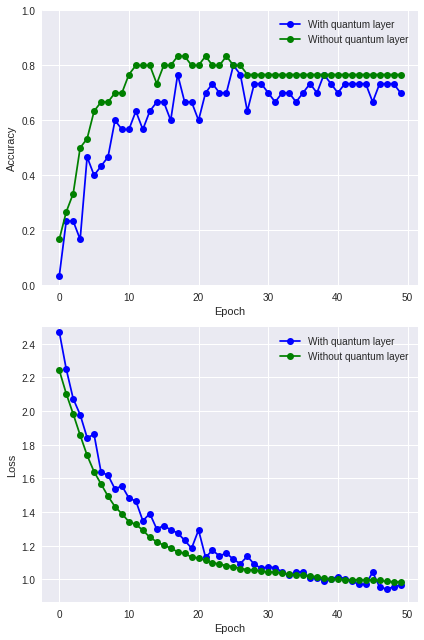

In [25]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2> Repeat = 5<h2>

In [26]:
q_train_images, q_test_images = Process(5) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


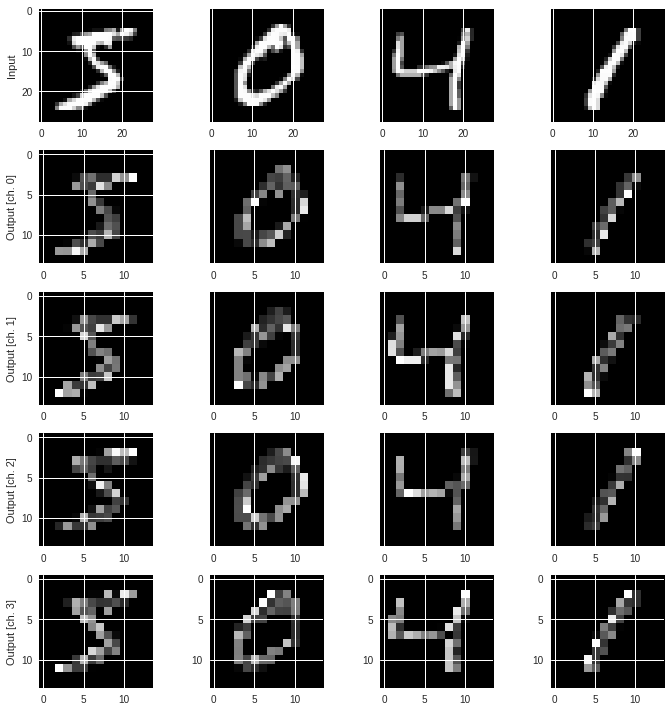

In [27]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [28]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 2.2591 - accuracy: 0.2400 - val_loss: 2.2091 - val_accuracy: 0.2000
Epoch 2/50
13/13 - 0s - loss: 2.0599 - accuracy: 0.4000 - val_loss: 2.1441 - val_accuracy: 0.3000
Epoch 3/50
13/13 - 0s - loss: 1.8843 - accuracy: 0.5600 - val_loss: 2.0853 - val_accuracy: 0.4000
Epoch 4/50
13/13 - 0s - loss: 1.7299 - accuracy: 0.7200 - val_loss: 2.0257 - val_accuracy: 0.3667
Epoch 5/50
13/13 - 0s - loss: 1.5844 - accuracy: 0.8400 - val_loss: 1.9595 - val_accuracy: 0.4333
Epoch 6/50
13/13 - 0s - loss: 1.4566 - accuracy: 0.8800 - val_loss: 1.9066 - val_accuracy: 0.4333
Epoch 7/50
13/13 - 0s - loss: 1.3343 - accuracy: 0.9400 - val_loss: 1.8592 - val_accuracy: 0.4667
Epoch 8/50
13/13 - 0s - loss: 1.2232 - accuracy: 0.9400 - val_loss: 1.8082 - val_accuracy: 0.5000
Epoch 9/50
13/13 - 0s - loss: 1.1249 - accuracy: 0.9400 - val_loss: 1.7614 - val_accuracy: 0.5333
Epoch 10/50
13/13 - 0s - loss: 1.0345 - accuracy: 0.9400 - val_loss: 1.7259 - val_accuracy: 0.5000
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1081 - accuracy: 1.0000 - val_loss: 1.0662 - val_accuracy: 0.7333
Epoch 35/50
13/13 - 0s - loss: 0.1023 - accuracy: 1.0000 - val_loss: 1.0624 - val_accuracy: 0.7333
Epoch 36/50
13/13 - 0s - loss: 0.0982 - accuracy: 1.0000 - val_loss: 1.0607 - val_accuracy: 0.7000
Epoch 37/50
13/13 - 0s - loss: 0.0938 - accuracy: 1.0000 - val_loss: 1.0567 - val_accuracy: 0.7333
Epoch 38/50
13/13 - 0s - loss: 0.0898 - accuracy: 1.0000 - val_loss: 1.0542 - val_accuracy: 0.7333
Epoch 39/50
13/13 - 0s - loss: 0.0862 - accuracy: 1.0000 - val_loss: 1.0447 - val_accuracy: 0.7333
Epoch 40/50
13/13 - 0s - loss: 0.0827 - accuracy: 1.0000 - val_loss: 1.0427 - val_accuracy: 0.7333
Epoch 41/50
13/13 - 0s - loss: 0.0794 - accuracy: 1.0000 - val_loss: 1.0386 - val_accuracy: 0.7333
Epoch 42/50
13/13 - 0s - loss: 0.0762 - accuracy: 1.0000 - val_loss: 1.0397 - val_accuracy: 0.7333
Epoch 43/50
13/13 - 0s - loss: 0.0733 - accuracy: 1.0000 - val_loss: 1.0391 - val_accuracy: 0.7333
Epoch 44/5

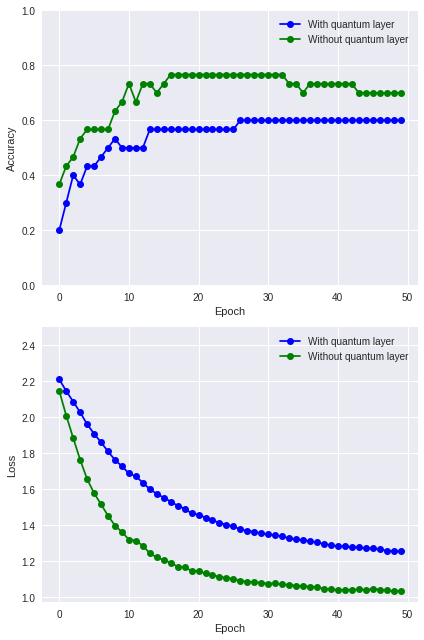

In [29]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 6</h2>

In [30]:
q_train_images, q_test_images = Process(6) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


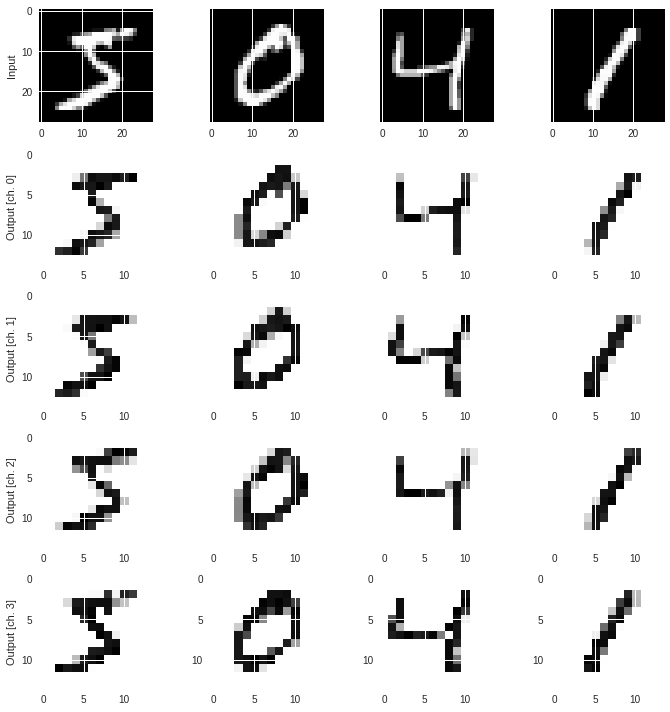

In [31]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [32]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 2.8648 - accuracy: 0.0600 - val_loss: 2.1900 - val_accuracy: 0.1333
Epoch 2/50
13/13 - 0s - loss: 2.3637 - accuracy: 0.1200 - val_loss: 2.1883 - val_accuracy: 0.1333
Epoch 3/50
13/13 - 0s - loss: 2.0504 - accuracy: 0.2600 - val_loss: 2.1334 - val_accuracy: 0.2333
Epoch 4/50
13/13 - 0s - loss: 1.7129 - accuracy: 0.4600 - val_loss: 1.8595 - val_accuracy: 0.4000
Epoch 5/50
13/13 - 0s - loss: 1.6334 - accuracy: 0.4800 - val_loss: 1.8016 - val_accuracy: 0.3667
Epoch 6/50
13/13 - 0s - loss: 1.5058 - accuracy: 0.5800 - val_loss: 1.8296 - val_accuracy: 0.3667
Epoch 7/50
13/13 - 0s - loss: 1.2861 - accuracy: 0.7000 - val_loss: 1.6096 - val_accuracy: 0.5333
Epoch 8/50
13/13 - 0s - loss: 1.1839 - accuracy: 0.7200 - val_loss: 1.5879 - val_accuracy: 0.5333
Epoch 9/50
13/13 - 0s - loss: 1.0367 - accuracy: 0.8000 - val_loss: 1.5207 - val_accuracy: 0.5333
Epoch 10/50
13/13 - 0s - loss: 0.8875 - accuracy: 0.9200 - val_loss: 1.5443 - val_accuracy: 0.5000
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1090 - accuracy: 1.0000 - val_loss: 1.0213 - val_accuracy: 0.7333
Epoch 35/50
13/13 - 0s - loss: 0.1032 - accuracy: 1.0000 - val_loss: 1.0169 - val_accuracy: 0.7333
Epoch 36/50
13/13 - 0s - loss: 0.0989 - accuracy: 1.0000 - val_loss: 1.0142 - val_accuracy: 0.7333
Epoch 37/50
13/13 - 0s - loss: 0.0945 - accuracy: 1.0000 - val_loss: 1.0105 - val_accuracy: 0.7333
Epoch 38/50
13/13 - 0s - loss: 0.0905 - accuracy: 1.0000 - val_loss: 1.0077 - val_accuracy: 0.7333
Epoch 39/50
13/13 - 0s - loss: 0.0869 - accuracy: 1.0000 - val_loss: 0.9981 - val_accuracy: 0.7333
Epoch 40/50
13/13 - 0s - loss: 0.0833 - accuracy: 1.0000 - val_loss: 0.9959 - val_accuracy: 0.7333
Epoch 41/50
13/13 - 0s - loss: 0.0799 - accuracy: 1.0000 - val_loss: 0.9922 - val_accuracy: 0.7333
Epoch 42/50
13/13 - 0s - loss: 0.0767 - accuracy: 1.0000 - val_loss: 0.9928 - val_accuracy: 0.7333
Epoch 43/50
13/13 - 0s - loss: 0.0738 - accuracy: 1.0000 - val_loss: 0.9923 - val_accuracy: 0.7333
Epoch 44/5

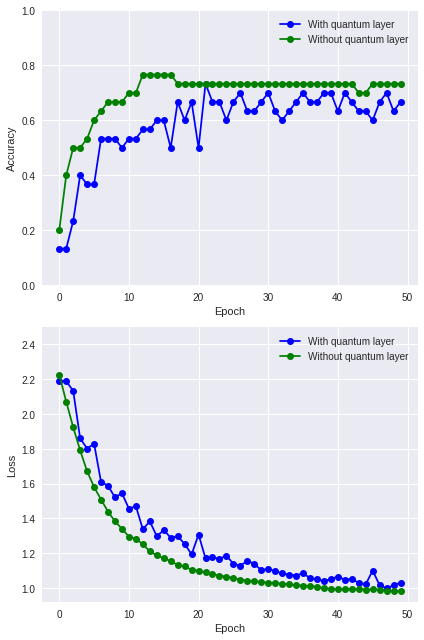

In [33]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 7 </h2> 

In [34]:
q_train_images, q_test_images = Process(7) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


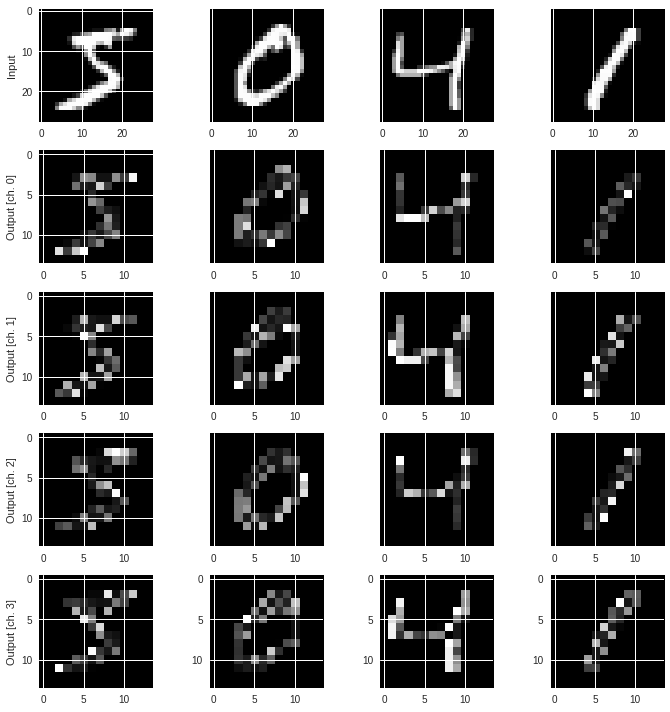

In [35]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [36]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 2.3156 - accuracy: 0.1000 - val_loss: 2.3249 - val_accuracy: 0.1000
Epoch 2/50
13/13 - 0s - loss: 2.1176 - accuracy: 0.3400 - val_loss: 2.2776 - val_accuracy: 0.1333
Epoch 3/50
13/13 - 0s - loss: 1.9483 - accuracy: 0.6000 - val_loss: 2.2332 - val_accuracy: 0.1000
Epoch 4/50
13/13 - 0s - loss: 1.7957 - accuracy: 0.6800 - val_loss: 2.1876 - val_accuracy: 0.1667
Epoch 5/50
13/13 - 0s - loss: 1.6511 - accuracy: 0.7600 - val_loss: 2.1347 - val_accuracy: 0.1667
Epoch 6/50
13/13 - 0s - loss: 1.5207 - accuracy: 0.8800 - val_loss: 2.0981 - val_accuracy: 0.2333
Epoch 7/50
13/13 - 0s - loss: 1.3988 - accuracy: 0.9000 - val_loss: 2.0577 - val_accuracy: 0.3667
Epoch 8/50
13/13 - 0s - loss: 1.2846 - accuracy: 0.9800 - val_loss: 2.0166 - val_accuracy: 0.3667
Epoch 9/50
13/13 - 0s - loss: 1.1814 - accuracy: 0.9800 - val_loss: 1.9782 - val_accuracy: 0.4000
Epoch 10/50
13/13 - 0s - loss: 1.0868 - accuracy: 0.9800 - val_loss: 1.9474 - val_accuracy: 0.4333
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1159 - accuracy: 1.0000 - val_loss: 0.9782 - val_accuracy: 0.7000
Epoch 35/50
13/13 - 0s - loss: 0.1096 - accuracy: 1.0000 - val_loss: 0.9737 - val_accuracy: 0.7000
Epoch 36/50
13/13 - 0s - loss: 0.1051 - accuracy: 1.0000 - val_loss: 0.9709 - val_accuracy: 0.7000
Epoch 37/50
13/13 - 0s - loss: 0.1004 - accuracy: 1.0000 - val_loss: 0.9659 - val_accuracy: 0.7000
Epoch 38/50
13/13 - 0s - loss: 0.0961 - accuracy: 1.0000 - val_loss: 0.9625 - val_accuracy: 0.7000
Epoch 39/50
13/13 - 0s - loss: 0.0922 - accuracy: 1.0000 - val_loss: 0.9529 - val_accuracy: 0.7000
Epoch 40/50
13/13 - 0s - loss: 0.0884 - accuracy: 1.0000 - val_loss: 0.9498 - val_accuracy: 0.7000
Epoch 41/50
13/13 - 0s - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.9456 - val_accuracy: 0.7000
Epoch 42/50
13/13 - 0s - loss: 0.0813 - accuracy: 1.0000 - val_loss: 0.9451 - val_accuracy: 0.7000
Epoch 43/50
13/13 - 0s - loss: 0.0782 - accuracy: 1.0000 - val_loss: 0.9431 - val_accuracy: 0.7000
Epoch 44/5

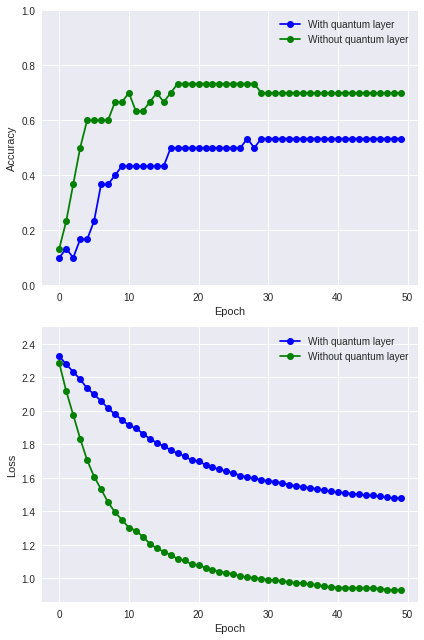

In [37]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 8</h2>

In [38]:
q_train_images, q_test_images = Process(8) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


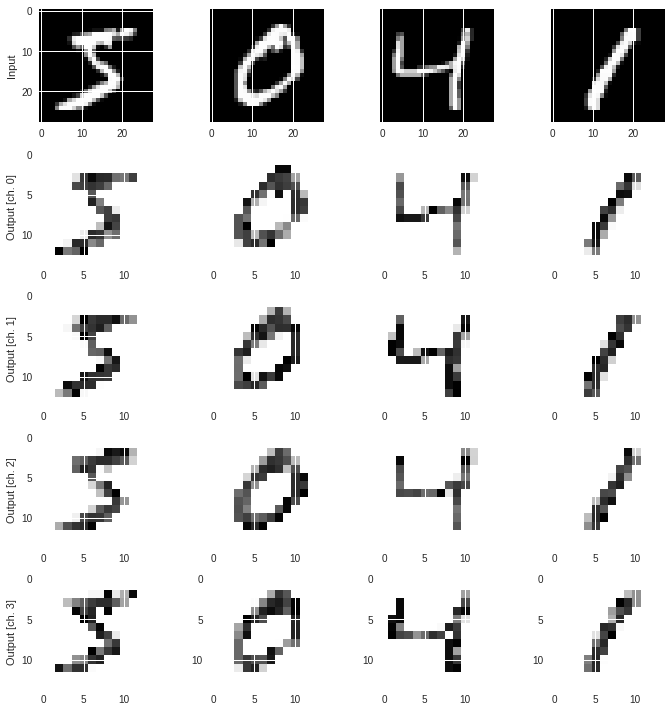

In [39]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [40]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 3.0133 - accuracy: 0.1400 - val_loss: 2.3478 - val_accuracy: 0.0333
Epoch 2/50
13/13 - 0s - loss: 2.5447 - accuracy: 0.1000 - val_loss: 2.2629 - val_accuracy: 0.3000
Epoch 3/50
13/13 - 0s - loss: 2.2510 - accuracy: 0.1800 - val_loss: 2.2633 - val_accuracy: 0.1667
Epoch 4/50
13/13 - 0s - loss: 1.9639 - accuracy: 0.3600 - val_loss: 1.9718 - val_accuracy: 0.3000
Epoch 5/50
13/13 - 0s - loss: 1.9317 - accuracy: 0.3600 - val_loss: 1.9527 - val_accuracy: 0.3333
Epoch 6/50
13/13 - 0s - loss: 1.8406 - accuracy: 0.4600 - val_loss: 1.9905 - val_accuracy: 0.4000
Epoch 7/50
13/13 - 0s - loss: 1.6255 - accuracy: 0.5200 - val_loss: 1.7428 - val_accuracy: 0.4000
Epoch 8/50
13/13 - 0s - loss: 1.5653 - accuracy: 0.5200 - val_loss: 1.7658 - val_accuracy: 0.4000
Epoch 9/50
13/13 - 0s - loss: 1.3972 - accuracy: 0.7200 - val_loss: 1.6539 - val_accuracy: 0.5667
Epoch 10/50
13/13 - 0s - loss: 1.2187 - accuracy: 0.8400 - val_loss: 1.7134 - val_accuracy: 0.5333
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1176 - accuracy: 1.0000 - val_loss: 1.0621 - val_accuracy: 0.6667
Epoch 35/50
13/13 - 0s - loss: 0.1112 - accuracy: 1.0000 - val_loss: 1.0581 - val_accuracy: 0.6667
Epoch 36/50
13/13 - 0s - loss: 0.1066 - accuracy: 1.0000 - val_loss: 1.0560 - val_accuracy: 0.6333
Epoch 37/50
13/13 - 0s - loss: 0.1019 - accuracy: 1.0000 - val_loss: 1.0523 - val_accuracy: 0.6667
Epoch 38/50
13/13 - 0s - loss: 0.0975 - accuracy: 1.0000 - val_loss: 1.0500 - val_accuracy: 0.6667
Epoch 39/50
13/13 - 0s - loss: 0.0936 - accuracy: 1.0000 - val_loss: 1.0411 - val_accuracy: 0.6667
Epoch 40/50
13/13 - 0s - loss: 0.0898 - accuracy: 1.0000 - val_loss: 1.0391 - val_accuracy: 0.6667
Epoch 41/50
13/13 - 0s - loss: 0.0862 - accuracy: 1.0000 - val_loss: 1.0357 - val_accuracy: 0.6667
Epoch 42/50
13/13 - 0s - loss: 0.0826 - accuracy: 1.0000 - val_loss: 1.0358 - val_accuracy: 0.6667
Epoch 43/50
13/13 - 0s - loss: 0.0795 - accuracy: 1.0000 - val_loss: 1.0354 - val_accuracy: 0.6667
Epoch 44/5

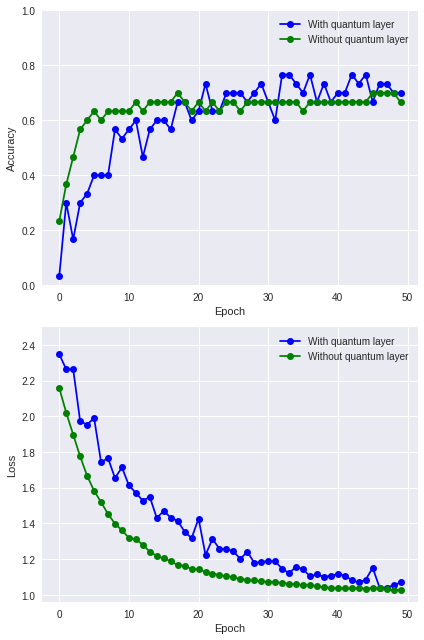

In [41]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 9</h2>

In [42]:
q_train_images, q_test_images = Process(9) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


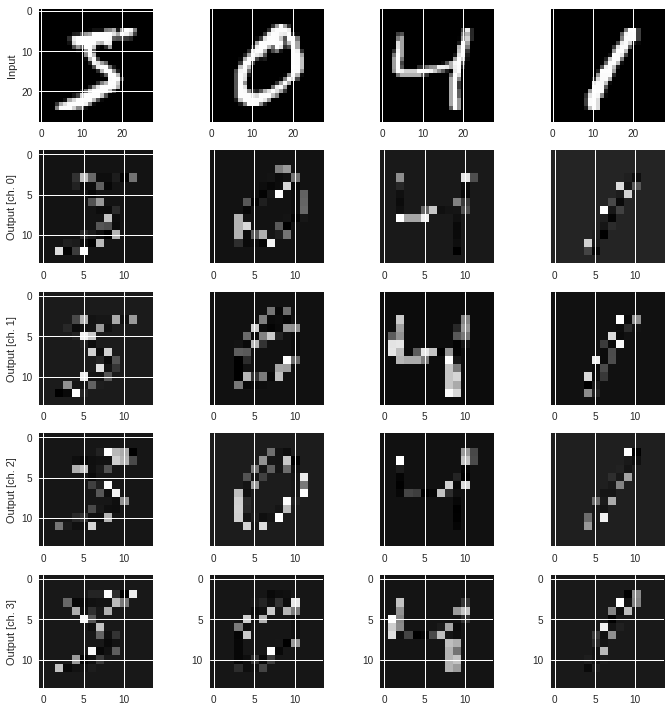

In [43]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [44]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 2.2739 - accuracy: 0.1000 - val_loss: 2.3875 - val_accuracy: 0.0333
Epoch 2/50
13/13 - 0s - loss: 2.0969 - accuracy: 0.2400 - val_loss: 2.3705 - val_accuracy: 0.0667
Epoch 3/50
13/13 - 0s - loss: 1.9443 - accuracy: 0.5800 - val_loss: 2.3530 - val_accuracy: 0.1000
Epoch 4/50
13/13 - 0s - loss: 1.7994 - accuracy: 0.8000 - val_loss: 2.3368 - val_accuracy: 0.1000
Epoch 5/50
13/13 - 0s - loss: 1.6629 - accuracy: 0.9000 - val_loss: 2.3170 - val_accuracy: 0.1000
Epoch 6/50
13/13 - 0s - loss: 1.5391 - accuracy: 0.9800 - val_loss: 2.3043 - val_accuracy: 0.1333
Epoch 7/50
13/13 - 0s - loss: 1.4189 - accuracy: 1.0000 - val_loss: 2.2892 - val_accuracy: 0.2000
Epoch 8/50
13/13 - 0s - loss: 1.3082 - accuracy: 1.0000 - val_loss: 2.2740 - val_accuracy: 0.2000
Epoch 9/50
13/13 - 0s - loss: 1.2066 - accuracy: 1.0000 - val_loss: 2.2593 - val_accuracy: 0.2000
Epoch 10/50
13/13 - 0s - loss: 1.1133 - accuracy: 1.0000 - val_loss: 2.2484 - val_accuracy: 0.2000
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1066 - accuracy: 1.0000 - val_loss: 1.0128 - val_accuracy: 0.7333
Epoch 35/50
13/13 - 0s - loss: 0.1011 - accuracy: 1.0000 - val_loss: 1.0086 - val_accuracy: 0.7333
Epoch 36/50
13/13 - 0s - loss: 0.0970 - accuracy: 1.0000 - val_loss: 1.0057 - val_accuracy: 0.7333
Epoch 37/50
13/13 - 0s - loss: 0.0928 - accuracy: 1.0000 - val_loss: 1.0013 - val_accuracy: 0.7333
Epoch 38/50
13/13 - 0s - loss: 0.0889 - accuracy: 1.0000 - val_loss: 0.9985 - val_accuracy: 0.7000
Epoch 39/50
13/13 - 0s - loss: 0.0854 - accuracy: 1.0000 - val_loss: 0.9891 - val_accuracy: 0.7000
Epoch 40/50
13/13 - 0s - loss: 0.0819 - accuracy: 1.0000 - val_loss: 0.9870 - val_accuracy: 0.7000
Epoch 41/50
13/13 - 0s - loss: 0.0787 - accuracy: 1.0000 - val_loss: 0.9823 - val_accuracy: 0.7000
Epoch 42/50
13/13 - 0s - loss: 0.0755 - accuracy: 1.0000 - val_loss: 0.9832 - val_accuracy: 0.7000
Epoch 43/50
13/13 - 0s - loss: 0.0727 - accuracy: 1.0000 - val_loss: 0.9818 - val_accuracy: 0.7000
Epoch 44/5

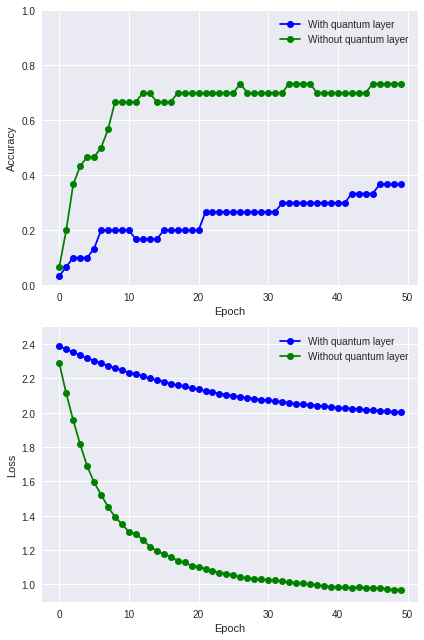

In [45]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Repeat = 10</h2>

In [46]:
q_train_images, q_test_images = Process(10) # Repeat Process(repeat)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


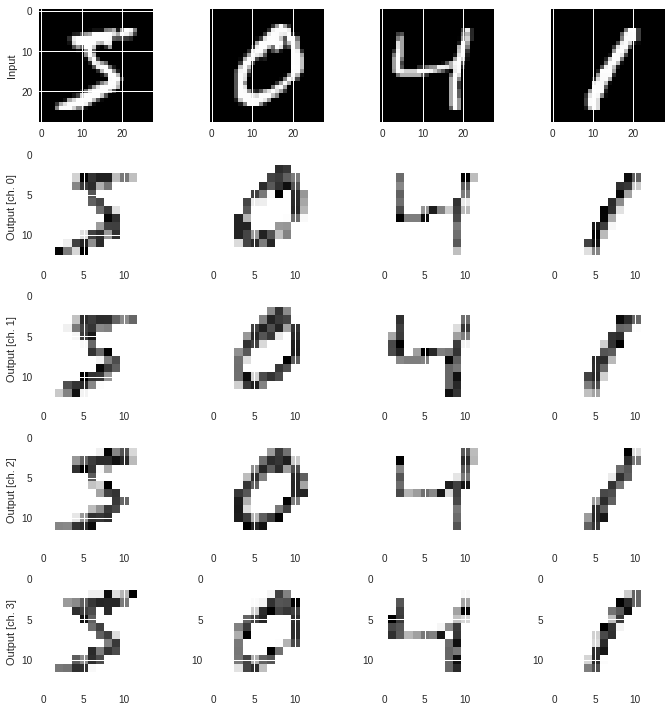

In [47]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [48]:
q_history, c_history = Train_model(50)

Epoch 1/50
13/13 - 0s - loss: 3.2166 - accuracy: 0.0600 - val_loss: 2.6254 - val_accuracy: 0.0333
Epoch 2/50
13/13 - 0s - loss: 2.5472 - accuracy: 0.1000 - val_loss: 2.3105 - val_accuracy: 0.2000
Epoch 3/50
13/13 - 0s - loss: 2.4265 - accuracy: 0.1600 - val_loss: 2.2266 - val_accuracy: 0.1333
Epoch 4/50
13/13 - 0s - loss: 2.1302 - accuracy: 0.2000 - val_loss: 2.1801 - val_accuracy: 0.1000
Epoch 5/50
13/13 - 0s - loss: 2.1147 - accuracy: 0.1800 - val_loss: 2.0311 - val_accuracy: 0.2667
Epoch 6/50
13/13 - 0s - loss: 2.0082 - accuracy: 0.3000 - val_loss: 2.1091 - val_accuracy: 0.2000
Epoch 7/50
13/13 - 0s - loss: 1.8022 - accuracy: 0.3600 - val_loss: 1.8925 - val_accuracy: 0.3667
Epoch 8/50
13/13 - 0s - loss: 1.7389 - accuracy: 0.4600 - val_loss: 1.9173 - val_accuracy: 0.2667
Epoch 9/50
13/13 - 0s - loss: 1.5957 - accuracy: 0.6400 - val_loss: 1.8030 - val_accuracy: 0.5667
Epoch 10/50
13/13 - 0s - loss: 1.4111 - accuracy: 0.7400 - val_loss: 1.8799 - val_accuracy: 0.3667
Epoch 11/50
13/13 -

Epoch 34/50
13/13 - 0s - loss: 0.1146 - accuracy: 1.0000 - val_loss: 1.0357 - val_accuracy: 0.7000
Epoch 35/50
13/13 - 0s - loss: 0.1085 - accuracy: 1.0000 - val_loss: 1.0317 - val_accuracy: 0.7000
Epoch 36/50
13/13 - 0s - loss: 0.1041 - accuracy: 1.0000 - val_loss: 1.0288 - val_accuracy: 0.7000
Epoch 37/50
13/13 - 0s - loss: 0.0994 - accuracy: 1.0000 - val_loss: 1.0253 - val_accuracy: 0.7000
Epoch 38/50
13/13 - 0s - loss: 0.0952 - accuracy: 1.0000 - val_loss: 1.0230 - val_accuracy: 0.7000
Epoch 39/50
13/13 - 0s - loss: 0.0914 - accuracy: 1.0000 - val_loss: 1.0135 - val_accuracy: 0.7000
Epoch 40/50
13/13 - 0s - loss: 0.0877 - accuracy: 1.0000 - val_loss: 1.0105 - val_accuracy: 0.7000
Epoch 41/50
13/13 - 0s - loss: 0.0841 - accuracy: 1.0000 - val_loss: 1.0074 - val_accuracy: 0.7000
Epoch 42/50
13/13 - 0s - loss: 0.0807 - accuracy: 1.0000 - val_loss: 1.0077 - val_accuracy: 0.7000
Epoch 43/50
13/13 - 0s - loss: 0.0777 - accuracy: 1.0000 - val_loss: 1.0069 - val_accuracy: 0.7000
Epoch 44/5

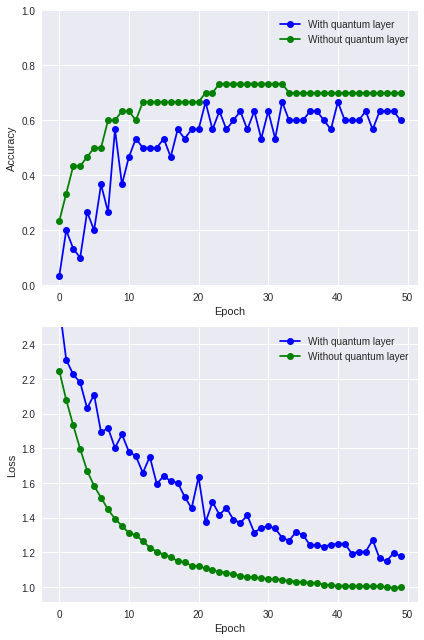

In [49]:

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h1>Epochs</h1>